# BERTopic Training

### Loading Data

Unlike LDA, we won't be using the preprocessed documents, but rather the unaltered versions.
Hence, we load the original ```.json``` files from the disk.

In [30]:
import json

# Try this with ../data/headlines/train.json
with open('../data/articles/train.json', 'r') as f:
    data = json.load(f)
    texts = [d['text'] for d in data]
    labels = [d['label'] for d in data]

    labels_map = {l: i for i, l in enumerate(set(labels))}
    labels_idx = [labels_map[l] for l in labels]


### Training the Model

We start by testing the default model used by BERTopic, which is SBERT.

In [31]:
from bertopic import BERTopic

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(texts)


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2023-06-14 22:07:24,540 - BERTopic - Transformed documents to Embeddings
2023-06-14 22:07:35,839 - BERTopic - Reduced dimensionality
2023-06-14 22:07:35,912 - BERTopic - Clustered reduced embeddings


As this process can take a while, we might want to save the model:

In [33]:
from os import makedirs
from os.path import join

makedirs(join('..', 'data', 'bert-models'), exist_ok=True)
topic_model.save(join('..', 'data', 'bert-models', 'model-base'))


**Re-Entry Point**

In [56]:
from bertopic import BERTopic
topic_model = BERTopic.load(join('..', 'data', 'bert-models', 'model-base'))


### Exploring the Results

While it is possible to evaluate the generated topics similarly to LDA, i.e., using coherence scores, LLM-based models are at an unfair disadvantage here. To properly compute coherence scores, we would need to preprocess the documents in the same way as we did for LDA. However, while LDA operates directly on this data, LLM-based models do not.

Further, due to the clustering method employed by BERTopic, there is no absolute set of topics. Rather, documents are clustered into topics in a hierarchical manner.
This allows for manual intervention, i.e., we can choose a level of granularity that suits our needs.

BERTopic allows us to visualize this hierarchy using a dendrogram. We can then select a level of granularity by cutting the dendrogram at a certain height.

In [34]:
topic_model.visualize_hierarchy()


### Evaluation

We can see our four main topics, which are then further divided into subtopics.
To evaluate the quality of these four main topics, we can use the same approach as we did for LDA, i.e., by comparing the generated topics to the ground truth using a confusion matrix.

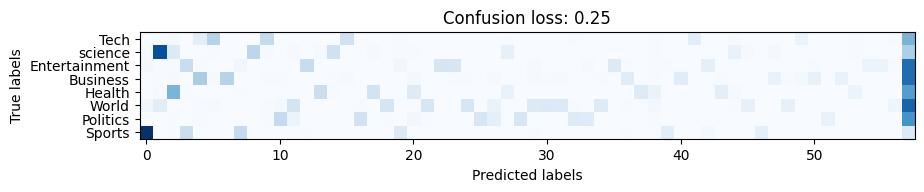

In [43]:
from helper.ConfusionLoss import plot_confusion_loss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plot_confusion_loss(labels, topics, ax=ax)


### Optimizing the Result

We can see, that we get a very low confusion loss, i.e., the topics from BERTopic correspond nicely with the ground truth. However, a lot of documents are not assigned to any topic (the last column), which might not be ideal.

BERTopic provides a method to handle this situation, called `reduce_outliers`.

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


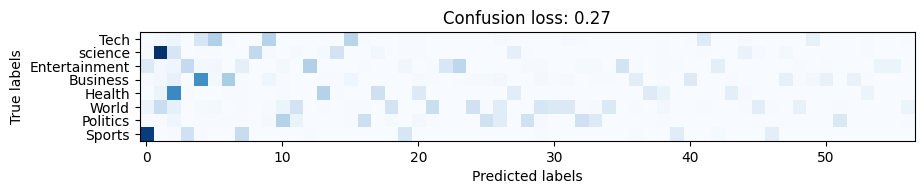

In [50]:
new_topics = topic_model.reduce_outliers(texts, topics)

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plot_confusion_loss(labels, new_topics, ax=ax)


While the confusion loss is slightly higher, we can see that the number of documents not assigned to any topic has decreased significantly.

BERTopic offers a similar method to reduce the number of topics, called `reduce_topics`. This method merges similar topics, which can be useful if we want to reduce the number of topics.

To find the number of topics you want to reduce, the dendrogram can be very useful, as it gives you a clear overview over the order in which topics will probably be merged.

2023-06-14 22:25:45,290 - BERTopic - Reduced number of topics from 58 to 12
100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


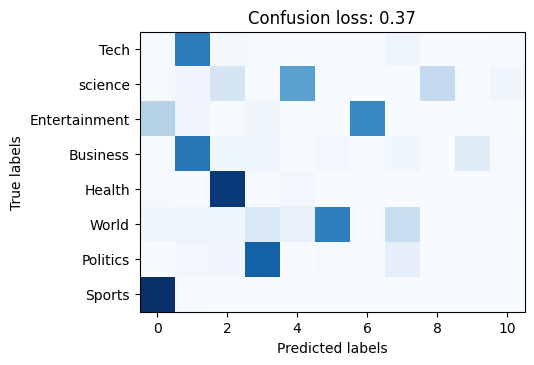

In [58]:
# Let's first restore the original model
topic_model = BERTopic.load(join('..', 'data', 'bert-models', 'model-base'))

topic_model.reduce_topics(texts, nr_topics=12)
merged_topics = topic_model.reduce_outliers(texts, topic_model.topics_)

plot_confusion_loss(labels, merged_topics)


We can see that, while increased, the confusion loss is still very low. This means that the topics are still very similar to the ground truth.

If you want even finer grained control over the topics to merge, you can use the `merge_topics` method, which allows you to merge topics based on their index.